In [10]:
import jax.numpy as jnp
import jax
import numpy as np
import pandas as pd
import d3p
from twinify.napsu_mq.napsu_mq import NapsuMQModel
from twinify.napsu_mq import rubins_rules as rubin
from twinify.napsu_mq import marginal_query
from twinify.napsu_mq.markov_network import MarkovNetwork
from twinify.napsu_mq import maximum_entropy_inference as mei
from twinify.napsu_mq import privacy_accounting
from tests.napsu_mq import lr
from tests.napsu_mq.binary_logistic_regression_generator import BinaryLogisticRegressionDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm

In [12]:
n = 2000
d = 4
n_syn_datasets = 100
n_syn_dataset = n

epsilon = 1.0
delta = n**(-2)

conf_levels = np.linspace(0.05, 0.95, 19)
true_params = jnp.array((0.4, 0.3, 0.0))


def gen_data(rng):
    data_gen = BinaryLogisticRegressionDataGenerator(true_params)
    data = data_gen.generate_data(n, rng)
    x_values = data_gen.x_values
    values_by_feature = data_gen.values_by_feature

    return data, x_values, values_by_feature

def get_dp_suff_stat(rng, queries, data):
    suff_stat = jnp.sum(queries.flatten()(data), axis=0)
    sensitivity = np.sqrt(suff_stat.shape[0])
    sigma_DP = privacy_accounting.sigma(epsilon, delta, sensitivity)
    dp_suff_stat = suff_stat + sigma_DP * jax.random.normal(key=rng, shape=suff_stat.shape)
    return dp_suff_stat, sigma_DP

def record(ci, conf_level, dim, repeat_ind):
    return {
        "has_coverage": int(ci[0] <= true_params[dim].item() <= ci[1]),
        "conf_level": conf_level,
        "dim": dim,
        "repeat_ind": repeat_ind
    }

In [13]:
n_repeats = 50
records = []
rng = d3p.random.PRNGKey(74249069)
rngs = d3p.random.split(rng, n_repeats)

for i in tqdm(range(n_repeats)):
    data_rng, inference_rng, sampling_rng = d3p.random.split(rngs[i], 3)
    data_rng = d3p.random.convert_to_jax_rng_key(data_rng)
    
    data, x_values, values_by_feature = gen_data(data_rng)
    data = pd.DataFrame(data, dtype="int")

    model = NapsuMQModel(column_feature_set=[tuple(range(d))], use_laplace_approximation=False)
    result = model.fit(
        data=data,
        rng=inference_rng,
        epsilon=epsilon,
        delta=delta,
        query_sets=[tuple(range(d))]
    )

    synthetic_dfs = result.generate(
        rng=sampling_rng, 
        num_data_per_parameter_sample=n_syn_dataset, 
        num_parameter_samples=n_syn_datasets,
        single_dataframe=False
    )

    syn_datasets = np.stack(synthetic_dfs, axis=0)

    q, u = lr.logistic_regression(syn_datasets, add_constant=False)
    for j in range(d - 1):
        for conf_level in conf_levels:
            qi = q[:,j]
            ui = u[:,j]
            inds = (np.isfinite(qi) & np.isfinite(ui))
            qi = qi[inds]
            ui = ui[inds]
            ci = rubin.conf_int(qi, ui, conf_level)
            records.append(record(ci, conf_level, j, i))


df = pd.DataFrame.from_records(records)

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 10845.00it/s]


4it [00:00, 11052.18it/s]


2it [00:00, 9653.17it/s]


4it [00:00, 14039.51it/s]


8it [00:00, 12543.71it/s]


8it [00:00, 25134.41it/s]


4it [00:00, 10070.36it/s]


8it [00:00, 22795.13it/s]


8it [00:00, 22595.58it/s]


4it [00:00, 10414.16it/s]


2it [00:00, 23237.14it/s]


4it [00:00, 32451.09it/s]


16it [00:00, 16062.44it/s]


2it [00:00, 28149.69it/s]


2it [00:00, 32896.50it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 450.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

4it [00:00, 44501.90it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 39945.75it/s]


8it [00:00, 31155.46it/s]


8it [00:00, 33588.02it/s]


4it [00:00, 31775.03it/s]


8it [00:00, 29511.37it/s]


8it [00:00, 33893.37it/s]


4it [00:00, 37786.52it/s]


2it [00:00, 36314.32it/s]


4it [00:00, 17242.77it/s]


16it [00:00, 20776.74it/s]


2it [00:00, 39199.10it/s]


2it [00:00, 41734.37it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1062.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59074.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 922.40it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51781.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 55553.70it/s]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 361.16it/s, 15 steps of size 2.45e-01. acc. prob=0.88]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 56299.38it/s]

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 369.03it/s, 7 steps of size 3.29e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4329.14it/s, 7 steps of size 2.67e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4189.05it/s, 7 steps of size 2.63e-01. acc. prob=0.92]

  0%|                                                                                                                                               

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 321.97it/s, 7 steps of size 1.89e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3984.50it/s, 7 steps of size 1.37e-01. acc. prob=0.91]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4094.20it/s, 7 steps of size 2.17e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 27730.94it/s]


4it [00:00, 36002.61it/s]


2it [00:00, 15060.34it/s]


4it [00:00, 35098.78it/s]


8it [00:00, 30559.59it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 363.17it/s, 7 steps of size 2.09e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4085.28it/s, 7 steps of size 2.12e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4049.20it/s, 7 steps of size 2.69e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 29026.33it/s]


4it [00:00, 40041.09it/s]


2it [00:00, 40920.04it/s]


4it [00:00, 41221.66it/s]


8it [00:00, 34204.31it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 360.03it/s, 7 steps of size 1.24e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3752.52it/s, 7 steps of size 2.33e-01. acc. prob=0.83]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3978.73it/s, 79 steps of size 1.59e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 38130.04it/s]


4it [00:00, 30783.88it/s]


2it [00:00, 18517.90it/s]


4it [00:00, 32017.59it/s]


8it [00:00, 33091.16it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 338.28it/s, 7 steps of size 3.09e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4070.42it/s, 7 steps of size 3.50e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4248.15it/s, 7 steps of size 3.50e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 39290.90it/s]


4it [00:00, 46474.28it/s]


2it [00:00, 33825.03it/s]


4it [00:00, 32451.09it/s]


8it [00:00, 35062.10it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 364.36it/s, 7 steps of size 2.46e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4209.37it/s, 7 steps of size 2.85e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4087.08it/s, 7 steps of size 2.58e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 33288.13it/s]


4it [00:00, 32451.09it/s]


2it [00:00, 40920.04it/s]


4it [00:00, 42908.48it/s]


8it [00:00, 27985.35it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 361.34it/s, 7 steps of size 2.91e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4142.42it/s, 7 steps of size 1.46e-01. acc. prob=0.91]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4251.11it/s, 7 steps of size 2.49e-01. acc. prob=0.87]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 39107.73it/s]


4it [00:00, 33554.43it/s]


2it [00:00, 13911.46it/s]


4it [00:00, 39199.10it/s]


8it [00:00, 30559.59it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 368.42it/s, 7 steps of size 3.18e-01. acc. prob=0.82]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4160.06it/s, 7 steps of size 2.09e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4083.17it/s, 7 steps of size 2.79e-01. acc. prob=0.84]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 38926.26it/s]


4it [00:00, 40427.03it/s]


2it [00:00, 12122.27it/s]


4it [00:00, 43577.18it/s]


8it [00:00, 35810.49it/s]


8it [00:

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4133.72it/s, 23 steps of size 2.13e-01. acc. prob=0.85]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4236.23it/s, 7 steps of size 2.41e-01. acc. prob=0.89]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 32263.88it/s]


4it [00:00, 34169.48it/s]


2it [00:00, 37117.73it/s]


4it [00:00, 40820.48it/s]


8it [00:00, 37744.02it/s]


8it [00:00, 35394.97it/s]


4it [00:00, 49490.31it/s]


8it [00:00, 29433.71it/s]


8it [00:00, 29203.16it/s]


4it [00:00, 43018.50it/s]


2it [00:00, 40136.88it/s]


4it [00:00, 34807.50it/s]


16it [00:00, 20460.02it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4172.23it/s, 7 steps of size 2.24e-01. acc. prob=0.91]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4054.48it/s, 7 steps of size 2.64e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 39290.90it/s]


4it [00:00, 38926.26it/s]


2it [00:00, 14716.86it/s]


4it [00:00, 36002.61it/s]


8it [00:00, 29537.35it/s]


8it [00:00, 24763.42it/s]


4it [00:00, 23530.46it/s]


8it [00:00, 34030.86it/s]


8it [00:00, 18477.11it/s]


4it [00:00, 33893.37it/s]


2it [00:00, 40721.40it/s]


4it [00:00, 47527.52it/s]


16it [00:00, 20122.60it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4045.30it/s, 7 steps of size 2.26e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4209.36it/s, 7 steps of size 2.40e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 35696.20it/s]


4it [00:00, 37701.61it/s]


2it [00:00, 34379.54it/s]


4it [00:00, 43018.50it/s]


8it [00:00, 34627.90it/s]


8it [00:00, 26317.20it/s]


4it [00:00, 40329.85it/s]


8it [00:00, 32640.50it/s]


8it [00:00, 25003.30it/s]


4it [00:00, 47527.52it/s]


2it [00:00, 33825.03it/s]


4it [00:00, 33621.68it/s]


16it [00:00, 18558.87it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4141.75it/s, 7 steps of size 2.57e-01. acc. prob=0.87]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 40427.03it/s]


4it [00:00, 17084.74it/s]


2it [00:00, 40920.04it/s]


4it [00:00, 44384.17it/s]


8it [00:00, 30643.32it/s]


8it [00:00, 26757.92it/s]


4it [00:00, 29641.72it/s]


8it [00:00, 33723.05it/s]


8it [00:00, 19362.05it/s]


4it [00:00, 34807.50it/s]


2it [00:00, 39383.14it/s]


4it [00:00, 29641.72it/s]


16it [00:00, 20329.86it/s]


2it [00:00, 38479.85it/s]


2it [00:00, 14388.69it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4259.69it/s, 7 steps of size 3.18e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 39107.73it/s]


4it [00:00, 28976.19it/s]


2it [00:00, 17403.75it/s]


4it [00:00, 33026.02it/s]


8it [00:00, 34204.31it/s]


8it [00:00, 30421.06it/s]


4it [00:00, 32451.09it/s]


8it [00:00, 36196.80it/s]


8it [00:00, 30174.85it/s]


4it [00:00, 29382.16it/s]


2it [00:00, 22489.57it/s]


4it [00:00, 26296.58it/s]


16it [00:00, 14211.96it/s]


2it [00:00, 39383.14it/s]


2it [00:00, 32263.88it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4230.79it/s, 15 steps of size 3.35e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 30783.88it/s]


4it [00:00, 44858.87it/s]


2it [00:00, 15279.80it/s]


4it [00:00, 30504.03it/s]


8it [00:00, 11267.44it/s]


8it [00:00, 17403.75it/s]


4it [00:00, 40041.09it/s]


8it [00:00, 28901.32it/s]


8it [00:00, 31126.56it/s]


4it [00:00, 38746.46it/s]


2it [00:00, 32263.88it/s]


4it [00:00, 17084.74it/s]


16it [00:00, 17331.83it/s]


2it [00:00, 17084.74it/s]


2it [00:00, 38479.85it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4011.31it/s, 7 steps of size 1.37e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 39662.45it/s]


4it [00:00, 39199.10it/s]


2it [00:00, 14614.30it/s]


4it [00:00, 44501.90it/s]


8it [00:00, 29720.49it/s]


8it [00:00, 27302.22it/s]


4it [00:00, 45964.98it/s]


8it [00:00, 30671.33it/s]


8it [00:00, 24528.09it/s]


4it [00:00, 41734.37it/s]


2it [00:00, 40721.40it/s]


4it [00:00, 41221.66it/s]


16it [00:00, 20146.76it/s]


2it [00:00, 37117.73it/s]


2it [00:00, 39945.75it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4266.07it/s, 3 steps of size 2.94e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 36472.21it/s]


4it [00:00, 33554.43it/s]


2it [00:00, 39199.10it/s]


4it [00:00, 38479.85it/s]


8it [00:00, 32513.98it/s]


8it [00:00, 31865.56it/s]


4it [00:00, 39945.75it/s]


8it [00:00, 33927.64it/s]


8it [00:00, 27985.35it/s]


4it [00:00, 42581.77it/s]


2it [00:00, 31775.03it/s]


4it [00:00, 48210.39it/s]


16it [00:00, 21076.90it/s]


2it [00:00, 35098.78it/s]


2it [00:00, 41734.37it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 37035.80it/s]


4it [00:00, 47662.55it/s]


2it [00:00, 12729.30it/s]


4it [00:00, 36631.48it/s]


8it [00:00, 27685.17it/s]


8it [00:00, 22459.46it/s]


4it [00:00, 45964.98it/s]


8it [00:00, 32513.98it/s]


8it [00:00, 26214.40it/s]


4it [00:00, 35772.32it/s]


2it [00:00, 39199.10it/s]


4it [00:00, 45590.26it/s]


16it [00:00, 19972.88it/s]


2it [00:00, 37786.52it/s]


2it [00:00, 42581.77it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1065.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 39290.90it/s]


4it [00:00, 44858.87it/s]


2it [00:00, 12826.62it/s]


4it [00:00, 41221.66it/s]


8it [00:00, 31744.97it/s]


8it [00:00, 25228.90it/s]


4it [00:00, 42153.81it/s]


8it [00:00, 30311.14it/s]


8it [00:00, 36711.63it/s]


4it [00:00, 36631.48it/s]


2it [00:00, 40136.88it/s]


4it [00:00, 39199.10it/s]


16it [00:00, 19021.79it/s]


2it [00:00, 37617.08it/s]


2it [00:00, 39945.75it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1081.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 37786.52it/s]


4it [00:00, 27776.85it/s]


2it [00:00, 32263.88it/s]


4it [00:00, 33354.31it/s]


8it [00:00, 34952.53it/s]


8it [00:00, 32672.28it/s]


4it [00:00, 40820.48it/s]


8it [00:00, 28703.53it/s]


8it [00:00, 33487.46it/s]


4it [00:00, 47662.55it/s]


2it [00:00, 34952.53it/s]


4it [00:00, 22104.37it/s]


16it [00:00, 20991.20it/s]


2it [00:00, 39945.75it/s]


2it [00:00, 36472.21it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1076.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 19807.81it/s]


4it [00:00, 42908.48it/s]


2it [00:00, 25343.23it/s]


4it [00:00, 40041.09it/s]


8it [00:00, 29001.24it/s]


8it [00:00, 28055.55it/s]


4it [00:00, 29589.45it/s]


8it [00:00, 20560.31it/s]


8it [00:00, 31126.56it/s]


4it [00:00, 25003.30it/s]


2it [00:00, 26715.31it/s]


4it [00:00, 12548.40it/s]


16it [00:00, 11740.53it/s]


2it [00:00, 33420.75it/s]


2it [00:00, 37786.52it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 813.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 39290.90it/s]


4it [00:00, 39290.90it/s]


2it [00:00, 33961.98it/s]


4it [00:00, 32017.59it/s]


8it [00:00, 30982.86it/s]


8it [00:00, 34030.86it/s]


4it [00:00, 42581.77it/s]


8it [00:00, 29101.85it/s]


8it [00:00, 37407.39it/s]


4it [00:00, 46995.00it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 29589.45it/s]


16it [00:00, 19605.28it/s]


2it [00:00, 27776.85it/s]


2it [00:00, 36314.32it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1051.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 36631.48it/s]


4it [00:00, 41630.81it/s]


2it [00:00, 33825.03it/s]


4it [00:00, 32768.00it/s]


8it [00:00, 35887.09it/s]


8it [00:00, 27103.74it/s]


4it [00:00, 45466.71it/s]


8it [00:00, 37076.72it/s]


8it [00:00, 29667.93it/s]


4it [00:00, 42581.77it/s]


2it [00:00, 33961.98it/s]


4it [00:00, 35025.50it/s]


16it [00:00, 19854.69it/s]


2it [00:00, 42366.71it/s]


2it [00:00, 40721.40it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1030.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 30559.59it/s]


4it [00:00, 43804.74it/s]


2it [00:00, 32768.00it/s]


4it [00:00, 19691.57it/s]


8it [00:00, 15441.52it/s]


8it [00:00, 33756.97it/s]


4it [00:00, 39945.75it/s]


8it [00:00, 24018.92it/s]


8it [00:00, 32896.50it/s]


4it [00:00, 41630.81it/s]


2it [00:00, 13530.01it/s]


4it [00:00, 43018.50it/s]


16it [00:00, 15868.73it/s]


2it [00:00, 36314.32it/s]


2it [00:00, 35098.78it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 960.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 37365.74it/s]


4it [00:00, 38391.80it/s]


2it [00:00, 31300.78it/s]


4it [00:00, 34521.02it/s]


8it [00:00, 30982.86it/s]


8it [00:00, 26234.90it/s]


4it [00:00, 47127.01it/s]


8it [00:00, 29101.85it/s]


8it [00:00, 23933.26it/s]


4it [00:00, 46995.00it/s]


2it [00:00, 39945.75it/s]


4it [00:00, 33893.37it/s]


16it [00:00, 20026.52it/s]


2it [00:00, 34379.54it/s]


2it [00:00, 21290.88it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1054.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 34239.22it/s]


4it [00:00, 37786.52it/s]


2it [00:00, 25575.02it/s]


4it [00:00, 29589.45it/s]


8it [00:00, 22354.72it/s]


8it [00:00, 37076.72it/s]


4it [00:00, 21481.71it/s]


8it [00:00, 19996.68it/s]


8it [00:00, 26951.35it/s]


4it [00:00, 33689.19it/s]


2it [00:00, 34379.54it/s]


4it [00:00, 41734.37it/s]


16it [00:00, 17857.60it/s]


2it [00:00, 35848.75it/s]


2it [00:00, 15887.52it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 950.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 36314.32it/s]


4it [00:00, 44384.17it/s]


2it [00:00, 27413.75it/s]


4it [00:00, 37701.61it/s]


8it [00:00, 32388.45it/s]


8it [00:00, 31625.29it/s]


4it [00:00, 44979.13it/s]


8it [00:00, 35283.31it/s]


8it [00:00, 34485.54it/s]


4it [00:00, 39568.91it/s]


2it [00:00, 43240.25it/s]


4it [00:00, 48349.33it/s]


16it [00:00, 20158.87it/s]


2it [00:00, 43464.29it/s]


2it [00:00, 39199.10it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1076.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 20510.04it/s]


4it [00:00, 44979.13it/s]


2it [00:00, 27324.46it/s]


4it [00:00, 44979.13it/s]


8it [00:00, 31011.49it/s]


8it [00:00, 37574.95it/s]


4it [00:00, 31476.95it/s]


8it [00:00, 30615.36it/s]


8it [00:00, 31126.56it/s]


4it [00:00, 45964.98it/s]


2it [00:00, 31300.78it/s]


4it [00:00, 25003.30it/s]


16it [00:00, 20170.98it/s]


2it [00:00, 39945.75it/s]


2it [00:00, 41527.76it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1051.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 35469.80it/s]


4it [00:00, 44384.17it/s]


2it [00:00, 20610.83it/s]


4it [00:00, 43129.09it/s]


8it [00:00, 33354.31it/s]


8it [00:00, 19599.55it/s]


4it [00:00, 39199.10it/s]


8it [00:00, 33487.46it/s]


8it [00:00, 28055.55it/s]


4it [00:00, 37035.80it/s]


2it [00:00, 36314.32it/s]


4it [00:00, 41943.04it/s]


16it [00:00, 20693.45it/s]


2it [00:00, 33961.98it/s]


2it [00:00, 38479.85it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1089.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

4it [00:00, 36792.14it/s]


2it [00:00, 29852.70it/s]


4it [00:00, 39568.91it/s]


8it [00:00, 30868.84it/s]


8it [00:00, 30982.86it/s]


4it [00:00, 44384.17it/s]


8it [00:00, 29330.80it/s]


8it [00:00, 32640.50it/s]


4it [00:00, 43919.41it/s]


2it [00:00, 42366.71it/s]


4it [00:00, 38836.15it/s]


16it [00:00, 21257.16it/s]


2it [00:00, 34521.02it/s]


2it [00:00, 35696.20it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1008.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49344.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1035.15it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62601.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 55711.82it/s]

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 363.81it/s, 7 steps of size 2.13e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 55977.37it/s]

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 365.50it/s, 7 steps of size 2.89e-01. acc. prob=0.85]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4174.08it/s, 7 steps of size 2.09e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4165.30it/s, 7 steps of size 2.89e-01. acc. prob=0.88]

  0%|                                                                                                                                               

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 360.77it/s, 7 steps of size 2.81e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4173.37it/s, 7 steps of size 2.46e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4251.44it/s, 7 steps of size 2.44e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 34807.50it/s]


4it [00:00, 42581.77it/s]


2it [00:00, 21236.98it/s]


4it [00:00, 42048.16it/s]


8it [00:00, 32263.88it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 369.54it/s, 7 steps of size 3.34e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4292.10it/s, 7 steps of size 3.65e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4326.44it/s, 7 steps of size 3.11e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 36631.48it/s]


4it [00:00, 36711.63it/s]


2it [00:00, 35246.25it/s]


4it [00:00, 32017.59it/s]


8it [00:00, 31126.56it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 354.56it/s, 7 steps of size 1.38e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4000.70it/s, 7 steps of size 2.18e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4111.11it/s, 7 steps of size 1.57e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 40136.88it/s]


4it [00:00, 37117.73it/s]


2it [00:00, 35098.78it/s]


4it [00:00, 41734.37it/s]


8it [00:00, 23382.88it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 365.24it/s, 7 steps of size 1.37e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4063.47it/s, 7 steps of size 1.75e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4052.34it/s, 7 steps of size 1.47e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 38130.04it/s]


4it [00:00, 38043.57it/s]


2it [00:00, 15169.27it/s]


4it [00:00, 45466.71it/s]


8it [00:00, 36041.28it/s]


8it [00:

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4290.21it/s, 7 steps of size 2.43e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4214.44it/s, 7 steps of size 2.16e-01. acc. prob=0.91]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 34169.48it/s]


4it [00:00, 39290.90it/s]


2it [00:00, 35098.78it/s]


4it [00:00, 45343.83it/s]


8it [00:00, 28777.39it/s]


8it [00:00, 18914.56it/s]


4it [00:00, 31011.49it/s]


8it [00:00, 32928.79it/s]


8it [00:00, 24174.66it/s]


4it [00:00, 44384.17it/s]


2it [00:00, 39945.75it/s]


4it [00:00, 39290.90it/s]


16it [00:00, 19206.89it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4286.86it/s, 7 steps of size 2.70e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4313.09it/s, 7 steps of size 3.00e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 19996.68it/s]


4it [00:00, 11806.63it/s]


2it [00:00, 26973.02it/s]


4it [00:00, 34807.50it/s]


8it [00:00, 18968.02it/s]


8it [00:00, 22534.88it/s]


4it [00:00, 14193.92it/s]


8it [00:00, 16921.04it/s]


8it [00:00, 16039.40it/s]


4it [00:00, 21845.33it/s]


2it [00:00, 21732.15it/s]


4it [00:00, 37365.74it/s]


16it [00:00, 12666.83it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4053.68it/s, 7 steps of size 1.82e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3775.56it/s, 7 steps of size 2.16e-01. acc. prob=0.83]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 35772.32it/s]


4it [00:00, 37365.74it/s]


2it [00:00, 34379.54it/s]


4it [00:00, 19691.57it/s]


8it [00:00, 19173.96it/s]


8it [00:00, 28244.47it/s]


4it [00:00, 31956.60it/s]


8it [00:00, 24018.92it/s]


8it [00:00, 21331.49it/s]


4it [00:00, 41221.66it/s]


2it [00:00, 33825.03it/s]


4it [00:00, 42153.81it/s]


16it [00:00, 15868.73it/s

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4250.03it/s, 15 steps of size 2.10e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4266.16it/s, 7 steps of size 2.61e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 39199.10it/s]


4it [00:00, 30504.03it/s]


2it [00:00, 40136.88it/s]


4it [00:00, 38926.26it/s]


8it [00:00, 31714.96it/s]


8it [00:00, 32388.45it/s]


4it [00:00, 44034.69it/s]


8it [00:00, 29203.16it/s]


8it [00:00, 31895.85it/s]


4it [00:00, 38043.57it/s]


2it [00:00, 40136.88it/s]


4it [00:00, 19328.59it/s]


16it [00:00, 19611.01it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4446.56it/s, 7 steps of size 3.20e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4382.84it/s, 7 steps of size 3.06e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 39662.45it/s]


4it [00:00, 39107.73it/s]


2it [00:00, 15738.48it/s]


4it [00:00, 42048.16it/s]


8it [00:00, 36832.53it/s]


8it [00:00, 26296.58it/s]


4it [00:00, 44979.13it/s]


8it [00:00, 21974.09it/s]


8it [00:00, 23530.46it/s]


4it [00:00, 35696.20it/s]


2it [00:00, 40920.04it/s]


4it [00:00, 44384.17it/s]


16it [00:00, 20225.70it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4098.49it/s, 7 steps of size 2.13e-01. acc. prob=0.91]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 36002.61it/s]


4it [00:00, 39107.73it/s]


2it [00:00, 34379.54it/s]


4it [00:00, 44384.17it/s]


8it [00:00, 25970.92it/s]


8it [00:00, 34204.31it/s]


4it [00:00, 21959.71it/s]


8it [00:00, 37914.61it/s]


8it [00:00, 29407.92it/s]


4it [00:00, 46603.38it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 35098.78it/s]


16it [00:00, 20225.70it/s]


2it [00:00, 39945.75it/s]


2it [00:00, 43240.25it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4090.58it/s, 7 steps of size 1.39e-01. acc. prob=0.91]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 37365.74it/s]


4it [00:00, 32451.09it/s]


2it [00:00, 33288.13it/s]


4it [00:00, 40820.48it/s]


8it [00:00, 31126.56it/s]


8it [00:00, 38836.15it/s]


4it [00:00, 34450.14it/s]


8it [00:00, 31011.49it/s]


8it [00:00, 33756.97it/s]


4it [00:00, 46474.28it/s]


2it [00:00, 38304.15it/s]


4it [00:00, 48770.98it/s]


16it [00:00, 20674.33it/s]


2it [00:00, 42581.77it/s]


2it [00:00, 12104.77it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4064.30it/s, 7 steps of size 2.29e-01. acc. prob=0.89]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 31011.49it/s]


4it [00:00, 39107.73it/s]


2it [00:00, 30283.78it/s]


4it [00:00, 34379.54it/s]


8it [00:00, 35734.22it/s]


8it [00:00, 23125.04it/s]


4it [00:00, 35098.78it/s]


8it [00:00, 36711.63it/s]


8it [00:00, 30283.78it/s]


4it [00:00, 31956.60it/s]


2it [00:00, 34521.02it/s]


4it [00:00, 33893.37it/s]


16it [00:00, 19163.01it/s]


2it [00:00, 35696.20it/s]


2it [00:00, 41943.04it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4376.29it/s, 31 steps of size 2.97e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 28197.00it/s]


4it [00:00, 33621.68it/s]


2it [00:00, 30283.78it/s]


4it [00:00, 26672.84it/s]


8it [00:00, 30283.78it/s]


8it [00:00, 21050.46it/s]


4it [00:00, 39199.10it/s]


8it [00:00, 26908.13it/s]


8it [00:00, 28581.29it/s]


4it [00:00, 39199.10it/s]


2it [00:00, 36314.32it/s]


4it [00:00, 44858.87it/s]


16it [00:00, 17581.57it/s]


2it [00:00, 35696.20it/s]


2it [00:00, 33420.75it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 36631.48it/s]


4it [00:00, 39945.75it/s]


2it [00:00, 37786.52it/s]


4it [00:00, 45590.26it/s]


8it [00:00, 29615.56it/s]


8it [00:00, 35887.09it/s]


4it [00:00, 42908.48it/s]


8it [00:00, 33893.37it/s]


8it [00:00, 38836.15it/s]


4it [00:00, 40427.03it/s]


2it [00:00, 39016.78it/s]


4it [00:00, 38479.85it/s]


16it [00:00, 18538.36it/s]


2it [00:00, 37786.52it/s]


2it [00:00, 34379.54it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1085.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [14:15<00:00, 17.10s/it]


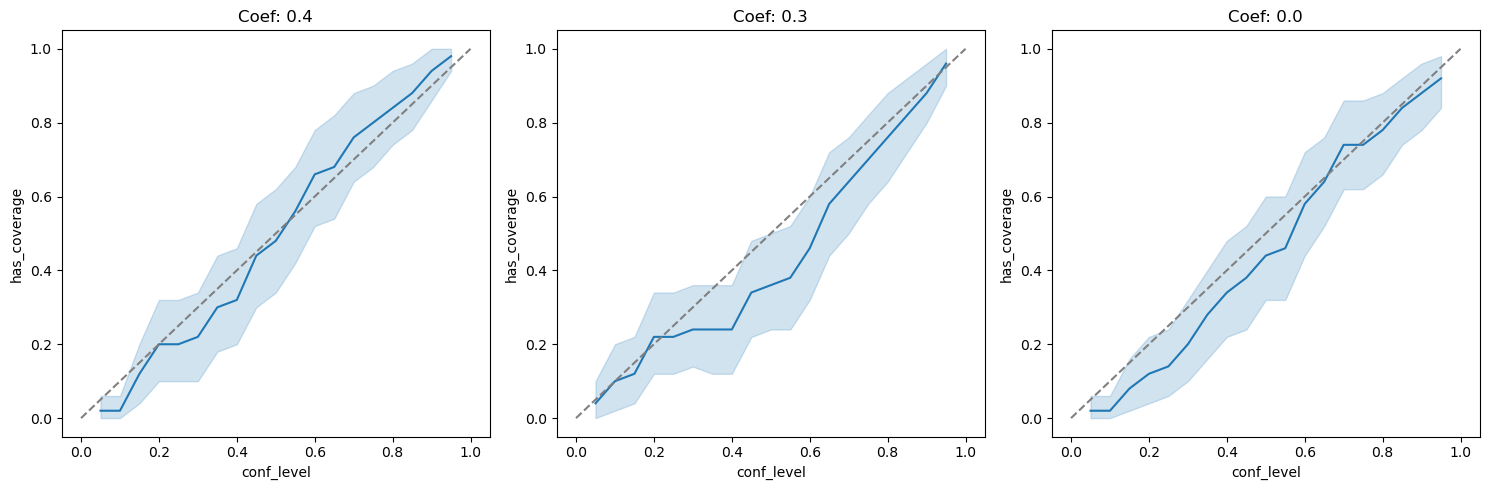

In [15]:
fig, axes = plt.subplots(1, d - 1, figsize=(5 * (d - 1), 5))
for i in range(d - 1):
    cdf = df[df.dim == i]
    ax = axes[i]
    sns.lineplot(data=cdf, x="conf_level", y="has_coverage", ax=ax)
    ax.plot((0, 1), (0, 1), linestyle="dashed", color="grey")
    ax.set_title("Coef: {}".format(true_params[i].item()))

plt.tight_layout()
plt.show()